In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Simple QA

In [277]:
model_names = ["gpt-4o-mini", "gpt-4o", "claude-3.5-sonnet", "gemini-v1.5-flash",
               "gemini-v1.5-pro", "llama31-70b", "llama31-405b"]

In [278]:
simple_qa_samples = {}
for model_name in model_names:
    simple_qa_samples[model_name] = pd.read_json("eval_samples/simple_qa_250_{}.jsonl".format(model_name), lines=True)
    simple_qa_samples[model_name+"-agent"] = pd.read_json("eval_samples/simple_qa_250_{}-agent.jsonl".format(model_name), lines=True)

simple_qa_samples["gemini-v1.5-flash-agent"] = pd.read_json("eval_samples/simple_qa_250-gemini-v1.5-flash-agent-ablation.jsonl", lines=True)
simple_qa_samples["ppl-llama31-70-agent"] = pd.read_json("eval_samples/simple_qa_250_llama-3.1-sonar-large-128k-online.jsonl", lines=True)
simple_qa_samples["ppl-llama31-405-agent"] = pd.read_json("eval_samples/simple_qa_250_llama-3.1-sonar-huge-128k-online.jsonl", lines=True)

In [279]:
network_error_ids = {}

for model_name in model_names:
    model_samples = simple_qa_samples[model_name]
    agent_model_samples = simple_qa_samples[model_name+"-agent"]
    ids = set()
    ids = ids.union(set(list(model_samples[model_samples["response"].str.lower().str.contains("network error due to high traffic")]["question_id"])))
    ids = ids.union(set(list(agent_model_samples[agent_model_samples["response"].str.lower().str.contains("network error due to high traffic")]["question_id"])))
    network_error_ids[model_name] = list(ids)
    
for model_name in model_names:
    simple_qa_samples[model_name] = simple_qa_samples[model_name][~simple_qa_samples[model_name]["question_id"].isin(network_error_ids[model_name])]
    simple_qa_samples[model_name+"-agent"] = simple_qa_samples[model_name+"-agent"][~simple_qa_samples[model_name+"-agent"]["question_id"].isin(network_error_ids[model_name])]

### Web Search Invocations

In [280]:
web_search_invoked = {}
for model_name in simple_qa_samples.keys():
    if 'agent' in model_name:
        web_search_invoked[model_name] = float((simple_qa_samples[model_name]["search_done"]).mean())
web_search_invoked

{'gpt-4o-mini-agent': 0.7967479674796748,
 'gpt-4o-agent': 0.7862903225806451,
 'claude-3.5-sonnet-agent': 1.0,
 'gemini-v1.5-flash-agent': 0.6382113821138211,
 'gemini-v1.5-pro-agent': 0.9605263157894737,
 'llama31-70b-agent': 0.631578947368421,
 'llama31-405b-agent': 0.26506024096385544,
 'ppl-llama31-70-agent': 0.908,
 'ppl-llama31-405-agent': 0.892}

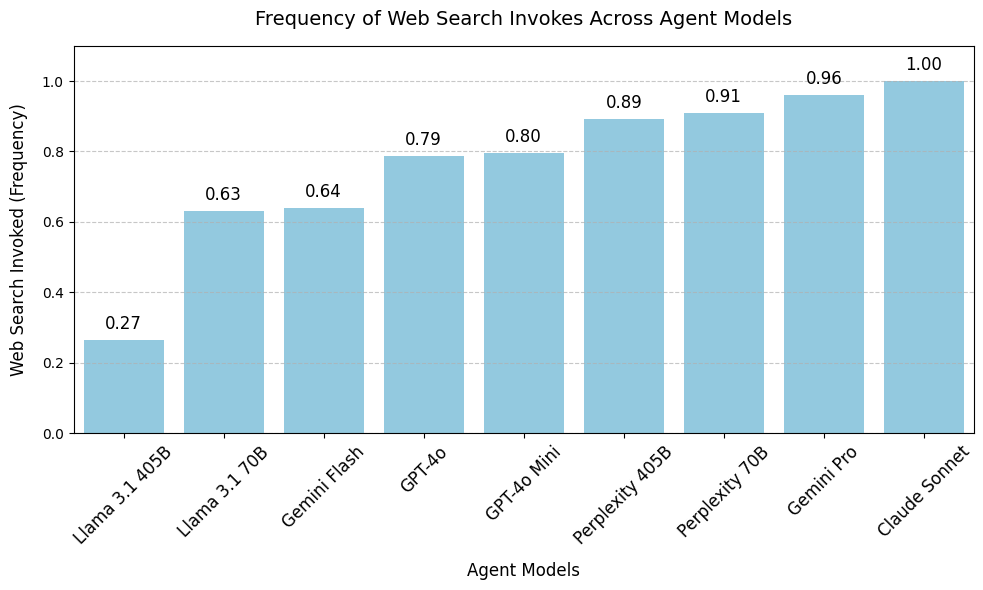

In [281]:
display_names = {"gpt-4o-mini-agent": "GPT-4o Mini", "gpt-4o-agent": "GPT-4o", "claude-3.5-sonnet-agent": "Claude Sonnet",
                "gemini-v1.5-flash-agent": "Gemini Flash", "gemini-v1.5-pro-agent": "Gemini Pro",
                "llama31-70b-agent": "Llama 3.1 70B", "llama31-405b-agent": "Llama 3.1 405B",
                "gemini-v1.5-flash-agent": "Gemini Flash", "ppl-llama31-70-agent": "Perplexity 70B",
                "ppl-llama31-405-agent": "Perplexity 405B"}

plot_data = pd.DataFrame(web_search_invoked.items(), columns=["Model", "Web Search Invoked"])
plot_data["Model"] = plot_data["Model"].map(display_names)
plot_data = plot_data.sort_values(by="Web Search Invoked", ascending=True).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Web Search Invoked", data=plot_data, color="skyblue")

for index, row in plot_data.iterrows():
    plt.text(x=index, 
             y=row["Web Search Invoked"] + 0.02,
             s=f'{row["Web Search Invoked"]:.2f}',
             ha='center', va='bottom', 
             fontsize=12, color='black')

plt.xlabel("Agent Models", fontsize=12, labelpad=10)
plt.ylabel("Web Search Invoked (Frequency)", fontsize=12, labelpad=10)
plt.xticks(rotation=45, fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Frequency of Web Search Invokes Across Agent Models", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

### Simple QA Web Search Improvement

In [282]:
simple_qa_results = {}
for model_name in model_names:
    simple_qa_results[model_name] = pd.read_json("eval_results/simple_qa_250_{}_results.jsonl".format(model_name), lines=True)
    simple_qa_results[model_name+"-agent"] = pd.read_json("eval_results/simple_qa_250_{}-agent_results.jsonl".format(model_name), lines=True)

simple_qa_results["ppl-llama31-70-agent"] = pd.read_json("eval_results/simple_qa_250_llama-3.1-sonar-large-128k-online_results.jsonl", lines=True)
simple_qa_results["ppl-llama31-405-agent"] = pd.read_json("eval_results/simple_qa_250_llama-3.1-sonar-huge-128k-online_results.jsonl", lines=True)
simple_qa_results["gemini-v1.5-flash-agent"] = pd.read_json("eval_results/simple_qa_250-gemini-v1.5-flash-agent-ablation_results.jsonl", lines=True)

for model_name in model_names:
    simple_qa_results[model_name] = simple_qa_results[model_name][~simple_qa_results[model_name]["question_id"].isin(network_error_ids[model_name])]
    simple_qa_results[model_name+"-agent"] = simple_qa_results[model_name+"-agent"][~simple_qa_results[model_name+"-agent"]["question_id"].isin(network_error_ids[model_name])]    

accuracy = {}
for model_name in simple_qa_results.keys():
    model_accuracy = float((simple_qa_results[model_name]["grade"] == "A").mean())
    accuracy[model_name] = model_accuracy
accuracy

{'gpt-4o-mini': 0.1016260162601626,
 'gpt-4o-mini-agent': 0.5975609756097561,
 'gpt-4o': 0.4435483870967742,
 'gpt-4o-agent': 0.7258064516129032,
 'claude-3.5-sonnet': 0.31092436974789917,
 'claude-3.5-sonnet-agent': 0.819327731092437,
 'gemini-v1.5-flash': 0.10569105691056911,
 'gemini-v1.5-flash-agent': 0.4065040650406504,
 'gemini-v1.5-pro': 0.2894736842105263,
 'gemini-v1.5-pro-agent': 0.7763157894736842,
 'llama31-70b': 0.15384615384615385,
 'llama31-70b-agent': 0.4939271255060729,
 'llama31-405b': 0.18875502008032127,
 'llama31-405b-agent': 0.43775100401606426,
 'ppl-llama31-70-agent': 0.172,
 'ppl-llama31-405-agent': 0.208}

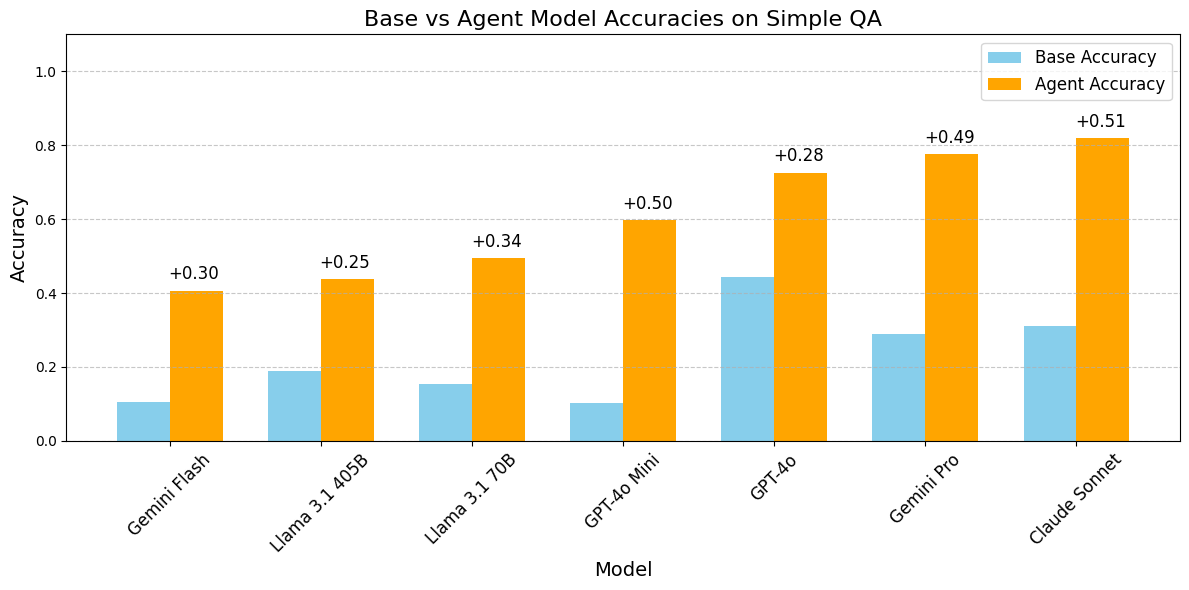

In [283]:
display_names = {"gpt-4o-mini-agent": "GPT-4o Mini", "gpt-4o-agent": "GPT-4o", "claude-3.5-sonnet-agent": "Claude Sonnet",
                "gemini-v1.5-flash-agent": "Gemini Flash", "gemini-v1.5-pro-agent": "Gemini Pro",
                "llama31-70b-agent": "Llama 3.1 70B", "llama31-405b-agent": "Llama 3.1 405B",
                "gemini-v1.5-flash-agent": "Gemini Flash", "ppl-llama31-70-agent": "Perplexity 70B",
                "ppl-llama31-405-agent": "Perplexity 405B"}

models = []
base_accuracies = []
agent_accuracies = []
improvements = []

for key in accuracy:
    if '-agent' in key and 'ppl' not in key:
        base_key = key.replace('-agent', '')
        models.append(display_names[key])
        base_accuracies.append(accuracy[base_key])
        agent_accuracies.append(accuracy[key])
        improvements.append(accuracy[key] - accuracy[base_key])

plot_data = pd.DataFrame({
    "Model": models,
    "Base Accuracy": base_accuracies,
    "Agent Accuracy": agent_accuracies,
    "Improvement": improvements
})
plot_data = plot_data.sort_values(by="Agent Accuracy", ascending=True).reset_index(drop=True)

x = np.arange(len(plot_data["Model"]))
width = 0.35
plt.figure(figsize=(12, 6))

base_bars = plt.bar(x - width / 2, plot_data["Base Accuracy"], width, label="Base Accuracy", color="skyblue")
agent_bars = plt.bar(x + width / 2, plot_data["Agent Accuracy"], width, label="Agent Accuracy", color="orange")

for i in range(len(models)):
    plt.text(x[i] + 0.16, 
             max(plot_data["Base Accuracy"][i], plot_data["Agent Accuracy"][i]) + 0.02,
             f'+{plot_data["Improvement"][i]:.2f}', 
             ha='center', va='bottom', fontsize=12)

plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Base vs Agent Model Accuracies on Simple QA", fontsize=16)
plt.xticks(x, plot_data["Model"], rotation=45, fontsize=12)
plt.ylim(0, 1.1)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

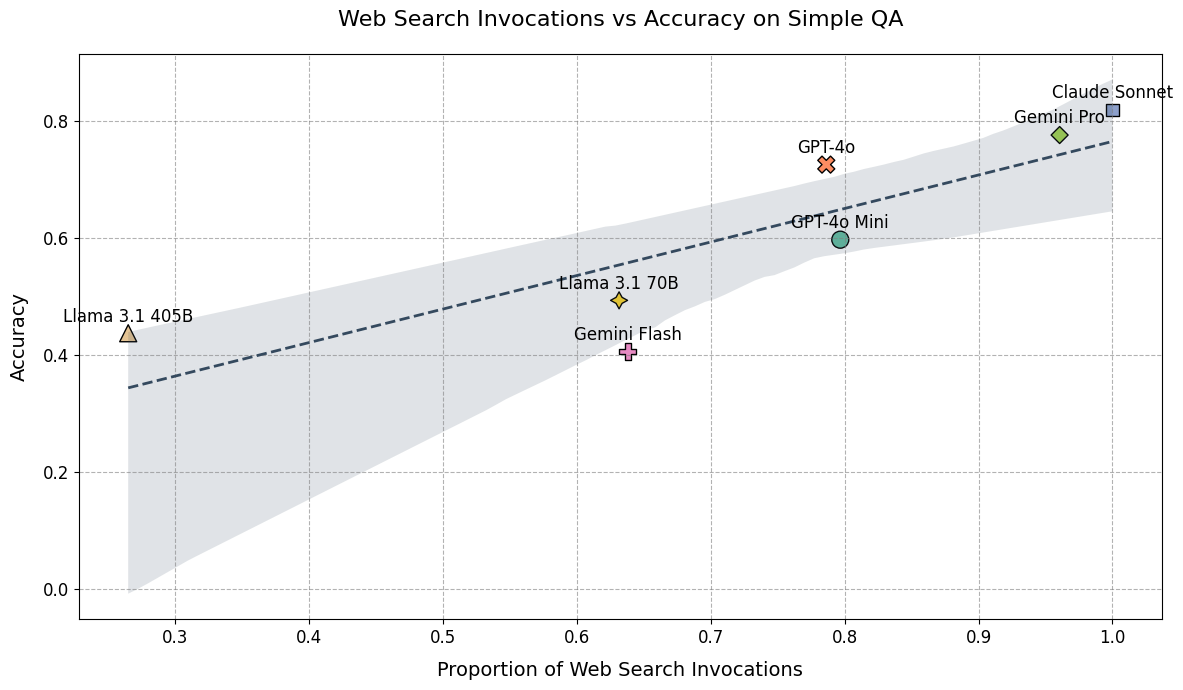

In [284]:
display_names = {"gpt-4o-mini-agent": "GPT-4o Mini", "gpt-4o-agent": "GPT-4o", "claude-3.5-sonnet-agent": "Claude Sonnet",
                "gemini-v1.5-flash-agent": "Gemini Flash", "gemini-v1.5-pro-agent": "Gemini Pro",
                "llama31-70b-agent": "Llama 3.1 70B", "llama31-405b-agent": "Llama 3.1 405B",
                "gemini-v1.5-flash-agent": "Gemini Flash", "ppl-llama31-70-agent": "Perplexity 70B",
                "ppl-llama31-405-agent": "Perplexity 405B"}

web_search_invoked_df = pd.DataFrame(web_search_invoked.items(), columns=["Model", "Web Search Invoked"])
simple_qa_accuracy_df = pd.DataFrame(accuracy.items(), columns=["Model", "Accuracy"])
plot_data = pd.merge(web_search_invoked_df, simple_qa_accuracy_df, on="Model")
plot_data = plot_data[~plot_data["Model"].str.contains("ppl-llama31")]
plot_data["Model"] = plot_data["Model"].map(display_names)

plt.figure(figsize=(12, 7))

scatter = sns.scatterplot(
    x="Web Search Invoked",
    y="Accuracy",
    data=plot_data,
    hue="Model",
    style="Model",
    palette="Set2",
    s=150,
    edgecolor="black"
)

sns.regplot(
    x="Web Search Invoked",
    y="Accuracy",
    data=plot_data,
    scatter=False,
    color="#34495e",
    line_kws={"linestyle": "dashed", "linewidth": 2}
)

for i in range(len(plot_data)):
    plt.text(
        plot_data["Web Search Invoked"].iloc[i],
        plot_data["Accuracy"].iloc[i] + 0.02,
        plot_data["Model"].iloc[i],
        fontsize=12,
        ha="center"
    )

plt.title("Web Search Invocations vs Accuracy on Simple QA", fontsize=16, pad=20)
plt.xlabel("Proportion of Web Search Invocations", fontsize=14, labelpad=10)
plt.ylabel("Accuracy", fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.6, color="gray")
plt.legend().set_visible(False)
plt.tight_layout()

plt.show()

### Web improvements and degradations

In [285]:
prop_corrections = {}

for model in simple_qa_results.keys():
    if 'agent' in model:
        continue
    model_results = simple_qa_results[model]
    agent_model_results = simple_qa_results[model+"-agent"]
    base_incorrect_ids = list(model_results[model_results["grade"] != "A"]["question_id"])
    model_results = model_results[model_results["question_id"].isin(base_incorrect_ids)]
    agent_model_results = agent_model_results[agent_model_results["question_id"].isin(base_incorrect_ids)]
    num_correct_agent = (agent_model_results["grade"] == "A").sum()
    num_incorrect_base = len(base_incorrect_ids)
    prop_corrections[model] = float(num_correct_agent / num_incorrect_base)

prop_corrections

{'gpt-4o-mini': 0.5746606334841629,
 'gpt-4o': 0.6086956521739131,
 'claude-3.5-sonnet': 0.7865853658536586,
 'gemini-v1.5-flash': 0.37727272727272726,
 'gemini-v1.5-pro': 0.7345679012345679,
 'llama31-70b': 0.4449760765550239,
 'llama31-405b': 0.3465346534653465}

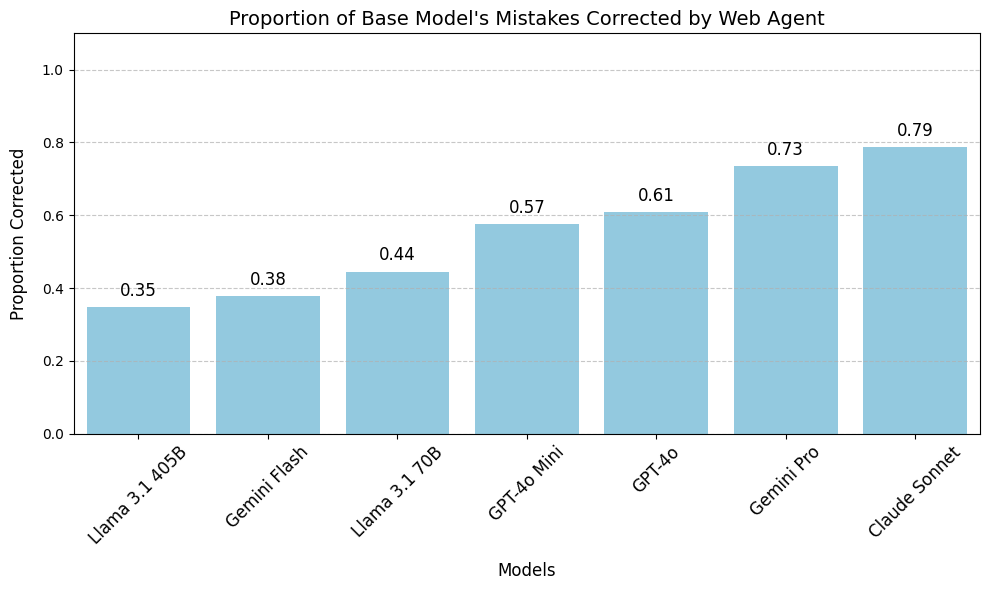

In [286]:
display_names = {"gpt-4o-mini": "GPT-4o Mini", "gpt-4o": "GPT-4o", "claude-3.5-sonnet": "Claude Sonnet",
                "gemini-v1.5-flash": "Gemini Flash", "gemini-v1.5-pro": "Gemini Pro",
                "llama31-70b": "Llama 3.1 70B", "llama31-405b": "Llama 3.1 405B",
                "gemini-v1.5-flash": "Gemini Flash"}

plot_data = pd.DataFrame(prop_corrections.items(), columns=["Model", "Proportion Corrected"])
plot_data["Model"] = plot_data["Model"].map(display_names)
plot_data = plot_data.sort_values(by="Proportion Corrected", ascending=True).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Proportion Corrected", data=plot_data, color="skyblue")

for index, row in plot_data.iterrows():
    plt.text(x=index, 
             y=row["Proportion Corrected"] + 0.02,
             s=f'{row["Proportion Corrected"]:.2f}',
             ha='center', va='bottom', 
             fontsize=12, color='black')

plt.xlabel("Models", fontsize=12, labelpad=10)
plt.ylabel("Proportion Corrected", fontsize=12, labelpad=10)
plt.xticks(rotation=45, fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Proportion of Base Model's Mistakes Corrected by Web Agent", fontsize=14)
plt.tight_layout()
plt.show()

In [287]:
simple_qa = pd.read_json("eval_inputs/simple_qa_250.jsonl", lines=True)

claude_base_results = simple_qa_results["claude-3.5-sonnet"]
claude_base_samples = simple_qa_samples["claude-3.5-sonnet"]
claude_agent_results = simple_qa_results["claude-3.5-sonnet-agent"]
claude_agent_samples = simple_qa_samples["claude-3.5-sonnet-agent"]

claude_base_results = pd.merge(claude_base_results, claude_base_samples, on="question_id")
claude_base_results = pd.merge(claude_base_results, simple_qa, on="question_id")
claude_agent_results = pd.merge(claude_agent_results, claude_agent_samples, on="question_id")
claude_agent_results = pd.merge(claude_agent_results, simple_qa, on="question_id")

base_incorrect_indices = claude_base_results[claude_base_results["grade"] != "A"]['question_id']
claude_base_results = claude_base_results.loc[claude_base_results["question_id"].isin(base_incorrect_indices)]
claude_agent_results = claude_agent_results.loc[claude_agent_results["question_id"].isin(base_incorrect_indices)]
agent_correct_ids = claude_agent_results[claude_agent_results["grade"] == "A"]["question_id"]

sample_point = agent_correct_ids.sample().iloc[0]
sample_point = "simple_qa_103"
print("Question ID: {}".format(sample_point))
print("### Question:\n{}\n".format(claude_base_results[claude_base_results["question_id"]==sample_point].iloc[0]['prompt']))
print("### Ground Truth Answer:\n{}\n".format(claude_base_results[claude_base_results["question_id"]==sample_point].iloc[0]['label']))
print("### Base Model Answer:\n{}\n".format(claude_base_results[claude_base_results["question_id"]==sample_point].iloc[0]['response']))
print("### Agent Model Answer:\n{}\n".format(claude_agent_results[claude_agent_results["question_id"]==sample_point].iloc[0]['response']))

Question ID: simple_qa_103
### Question:
What is the chemical name of the drug previously known to treat bacterial infections that Dr. William Schwartz discovered also acts as a diuretic in people with congestive heart failure?

### Ground Truth Answer:
Sulfanilamide.

### Base Model Answer:
Chlorothiazide (marketed as Diuril) was the drug that Dr. William Schwartz discovered had diuretic properties in people with congestive heart failure, despite it originally being developed as an antibacterial medication. This discovery in the late 1950s led to the development of thiazide diuretics, which became an important class of drugs for treating hypertension and heart failure.

### Agent Model Answer:
Based on the provided reference materials, the antibiotic sulfanilamide was discovered by Dr. William Schwartz to increase sodium excretion in patients with heart failure, which led to the development of modern diuretic drugs. This observation was noted in the Wikipedia article about William Sch

In [288]:
prop_incorrections = {}

for model in simple_qa_results.keys():
    if 'agent' in model:
        continue
    model_results = simple_qa_results[model]
    agent_model_results = simple_qa_results[model+"-agent"]
    base_correct_ids = list(model_results[model_results["grade"] == "A"]["question_id"])
    model_results = model_results[model_results["question_id"].isin(base_correct_ids)]
    agent_model_results = agent_model_results[agent_model_results["question_id"].isin(base_correct_ids)]
    num_correct_base = len(base_correct_ids)
    num_incorrect_agent = (agent_model_results["grade"] != "A").sum()
    prop_incorrections[model] = float(num_incorrect_agent / num_correct_base)

prop_incorrections

{'gpt-4o-mini': 0.2,
 'gpt-4o': 0.12727272727272726,
 'claude-3.5-sonnet': 0.10810810810810811,
 'gemini-v1.5-flash': 0.34615384615384615,
 'gemini-v1.5-pro': 0.12121212121212122,
 'llama31-70b': 0.23684210526315788,
 'llama31-405b': 0.1702127659574468}

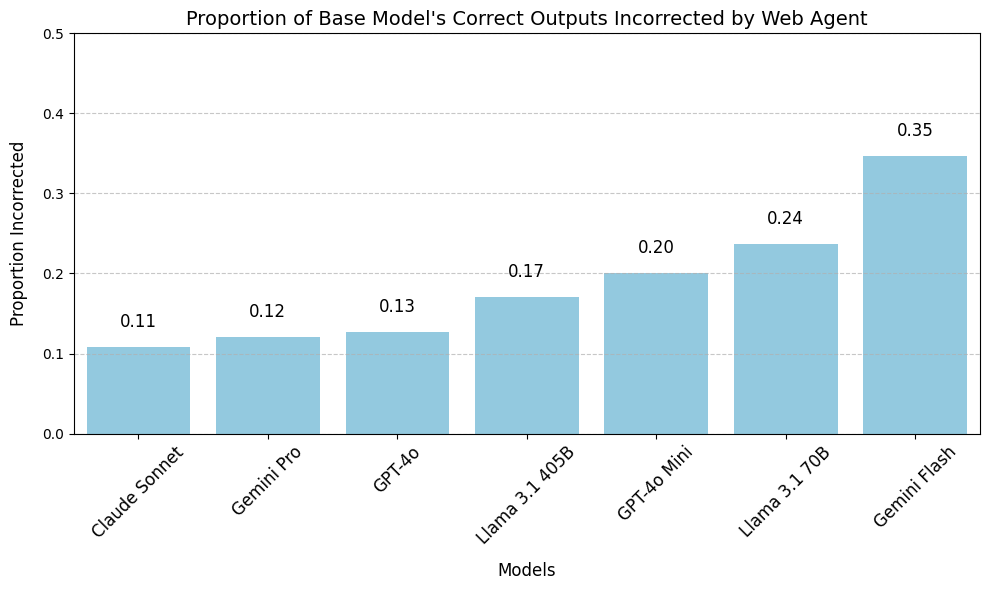

In [289]:
display_names = {"gpt-4o-mini": "GPT-4o Mini", "gpt-4o": "GPT-4o", "claude-3.5-sonnet": "Claude Sonnet",
                "gemini-v1.5-flash": "Gemini Flash", "gemini-v1.5-pro": "Gemini Pro",
                "llama31-70b": "Llama 3.1 70B", "llama31-405b": "Llama 3.1 405B",
                "gemini-v1.5-flash": "Gemini Flash"}

plot_data = pd.DataFrame(prop_incorrections.items(), columns=["Model", "Proportion Incorrected"])
plot_data["Model"] = plot_data["Model"].map(display_names)
plot_data = plot_data.sort_values(by="Proportion Incorrected", ascending=True).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Proportion Incorrected", data=plot_data, color="skyblue")

for index, row in plot_data.iterrows():
    plt.text(x=index, 
             y=row["Proportion Incorrected"] + 0.02,
             s=f'{row["Proportion Incorrected"]:.2f}',
             ha='center', va='bottom', 
             fontsize=12, color='black')

plt.xlabel("Models", fontsize=12, labelpad=10)
plt.ylabel("Proportion Incorrected", fontsize=12, labelpad=10)
plt.xticks(rotation=45, fontsize=12)
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Proportion of Base Model's Correct Outputs Incorrected by Web Agent", fontsize=14)
plt.tight_layout()
plt.show()

In [290]:
simple_qa = pd.read_json("eval_inputs/simple_qa_250.jsonl", lines=True)

gemini_base_results = simple_qa_results["gemini-v1.5-flash"]
gemini_base_samples = simple_qa_samples["gemini-v1.5-flash"]
gemini_agent_results = simple_qa_results["gemini-v1.5-flash-agent"]
gemini_agent_samples = simple_qa_samples["gemini-v1.5-flash-agent"]

gemini_base_results = pd.merge(gemini_base_results, gemini_base_samples, on="question_id")
gemini_base_results = pd.merge(gemini_base_results, simple_qa, on="question_id")
gemini_agent_results = pd.merge(gemini_agent_results, gemini_agent_samples, on="question_id")
gemini_agent_results = pd.merge(gemini_agent_results, simple_qa, on="question_id")

base_correct_ids = gemini_base_results[gemini_base_results["grade"] == "A"]['question_id']
gemini_base_results = gemini_base_results[gemini_base_results["question_id"].isin(base_correct_ids)]
gemini_agent_results = gemini_agent_results[gemini_agent_results["question_id"].isin(base_correct_ids)]
agent_incorrect_ids = gemini_agent_results[gemini_agent_results["grade"] != "A"]['question_id']

sample_point = agent_incorrect_ids.sample().iloc[0]
print("Question ID: {}".format(sample_point))
print("### Question:\n{}\n".format(gemini_base_results[gemini_base_results["question_id"]==sample_point].iloc[0]['prompt']))
print("### Ground Truth Answer:\n{}\n".format(gemini_base_results[gemini_base_results["question_id"]==sample_point].iloc[0]['label']))
print("### Base Model Answer:\n{}\n".format(gemini_base_results[gemini_base_results["question_id"]==sample_point].iloc[0]['response']))
print("### Agent Model Answer:\n{}\n".format(gemini_agent_results[gemini_agent_results["question_id"]==sample_point].iloc[0]['response']))

Question ID: simple_qa_32
### Question:
What four health organizations wrote to President John F. Kennedy calling for a National Commission on Smoking?

### Ground Truth Answer:
American Cancer Society, the American Public Health Association, the American Heart Association, and the National Tuberculosis Association

### Base Model Answer:
The four health organizations that wrote to President John F. Kennedy in 1962 urging the creation of a National Commission on Smoking were:

1. The American Cancer Society
2. The American Heart Association
3. The American Public Health Association
4. The National Tuberculosis Association

### Agent Model Answer:
This article doesn't name four health organizations that wrote to President Kennedy advocating for a National Commission on Smoking.  It focuses on the Surgeon General's report and its impact, not the lobbying efforts leading up to it.  The article mentions the Royal College of Physicians in London releasing a report, but that was not a US org

### Simple QA vs Arena Hard

In [291]:
model_names = ["gpt-4o-mini", "gpt-4o", "claude-3.5-sonnet", "gemini-v1.5-flash",
               "gemini-v1.5-pro", "llama31-70b", "llama31-405b"]

In [292]:
arena_hard_samples = {}
for model_name in model_names:
    arena_hard_samples[model_name] = pd.read_json("eval_samples/arena_hard_50_{}.jsonl".format(model_name), lines=True)
    arena_hard_samples[model_name+"-agent"] = pd.read_json("eval_samples/arena_hard_50_{}-agent.jsonl".format(model_name), lines=True)

In [293]:
network_error_ids = {}

for model_name in model_names:
    model_samples = arena_hard_samples[model_name]
    agent_model_samples = arena_hard_samples[model_name+"-agent"]
    ids = set()
    ids = ids.union(set(list(model_samples[model_samples["response"].str.lower().str.contains("network error due to high traffic")]["question_id"])))
    ids = ids.union(set(list(agent_model_samples[agent_model_samples["response"].str.lower().str.contains("network error due to high traffic")]["question_id"])))
    network_error_ids[model_name] = list(ids)
    
for model_name in model_names:
    arena_hard_samples[model_name] = arena_hard_samples[model_name][~arena_hard_samples[model_name]["question_id"].isin(network_error_ids[model_name])]
    arena_hard_samples[model_name+"-agent"] = arena_hard_samples[model_name+"-agent"][~arena_hard_samples[model_name+"-agent"]["question_id"].isin(network_error_ids[model_name])]

In [294]:
arena_hard_results = {}
for model_name in model_names:
    arena_hard_results[model_name] = pd.read_json("eval_results/arena_hard_{}.jsonl".format(model_name), lines=True)
    arena_hard_results[model_name+"-agent"] = pd.read_json("eval_results/arena_hard_{}.jsonl".format(model_name), lines=True)

for model_name in model_names:
    arena_hard_results[model_name] = arena_hard_results[model_name][~arena_hard_results[model_name]["question_id"].isin(network_error_ids[model_name])]
    arena_hard_results[model_name+"-agent"] = arena_hard_results[model_name+"-agent"][~arena_hard_results[model_name+"-agent"]["question_id"].isin(network_error_ids[model_name])]    

winrate = {}
for model_name in arena_hard_results.keys():
    if 'agent' in model_name:
        model_winrate = float((arena_hard_results[model_name]["grade"] == "agent").mean())
        winrate[model_name] = model_winrate
    else:
        model_winrate = float((arena_hard_results[model_name]["grade"] == "base").mean())
        winrate[model_name] = model_winrate
winrate

{'gpt-4o-mini': 0.6326530612244898,
 'gpt-4o-mini-agent': 0.2653061224489796,
 'gpt-4o': 0.36,
 'gpt-4o-agent': 0.5,
 'claude-3.5-sonnet': 0.6363636363636364,
 'claude-3.5-sonnet-agent': 0.3181818181818182,
 'gemini-v1.5-flash': 0.76,
 'gemini-v1.5-flash-agent': 0.22,
 'gemini-v1.5-pro': 0.8163265306122449,
 'gemini-v1.5-pro-agent': 0.16326530612244897,
 'llama31-70b': 0.8260869565217391,
 'llama31-70b-agent': 0.15217391304347827,
 'llama31-405b': 0.7755102040816326,
 'llama31-405b-agent': 0.20408163265306123}

In [295]:
accuracy

{'gpt-4o-mini': 0.1016260162601626,
 'gpt-4o-mini-agent': 0.5975609756097561,
 'gpt-4o': 0.4435483870967742,
 'gpt-4o-agent': 0.7258064516129032,
 'claude-3.5-sonnet': 0.31092436974789917,
 'claude-3.5-sonnet-agent': 0.819327731092437,
 'gemini-v1.5-flash': 0.10569105691056911,
 'gemini-v1.5-flash-agent': 0.4065040650406504,
 'gemini-v1.5-pro': 0.2894736842105263,
 'gemini-v1.5-pro-agent': 0.7763157894736842,
 'llama31-70b': 0.15384615384615385,
 'llama31-70b-agent': 0.4939271255060729,
 'llama31-405b': 0.18875502008032127,
 'llama31-405b-agent': 0.43775100401606426,
 'ppl-llama31-70-agent': 0.172,
 'ppl-llama31-405-agent': 0.208}

In [301]:
display_names = {
    "gpt-4o-mini": "GPT-4o Mini",
    "gpt-4o-mini-agent": "GPT-4o Mini Agent",
    "gpt-4o": "GPT-4o",
    "gpt-4o-agent": "GPT-4o Agent",
    "claude-3.5-sonnet": "Claude Sonnet",
    "claude-3.5-sonnet-agent": "Claude Sonnet Agent",
    "gemini-v1.5-flash": "Gemini Flash",
    "gemini-v1.5-flash-agent": "Gemini Flash Agent",
    "gemini-v1.5-pro": "Gemini Pro",
    "gemini-v1.5-pro-agent": "Gemini Pro Agent",
    "llama31-70b": "Llama 3.1 70B",
    "llama31-70b-agent": "Llama 3.1 70B Agent",
    "llama31-405b": "Llama 3.1 405B",
    "llama31-405b-agent": "Llama 3.1 405B Agent",
}

# Convert data to DataFrame
accuracy_df = pd.DataFrame(accuracy.items(), columns=["Model", "Simple QA Accuracy"])
win_rate_df = pd.DataFrame(winrate.items(), columns=["Model", "Win Rate"])

plot_data = pd.merge(accuracy_df, win_rate_df, on="Model")
plot_data["Model"] = plot_data["Model"].map(display_names)

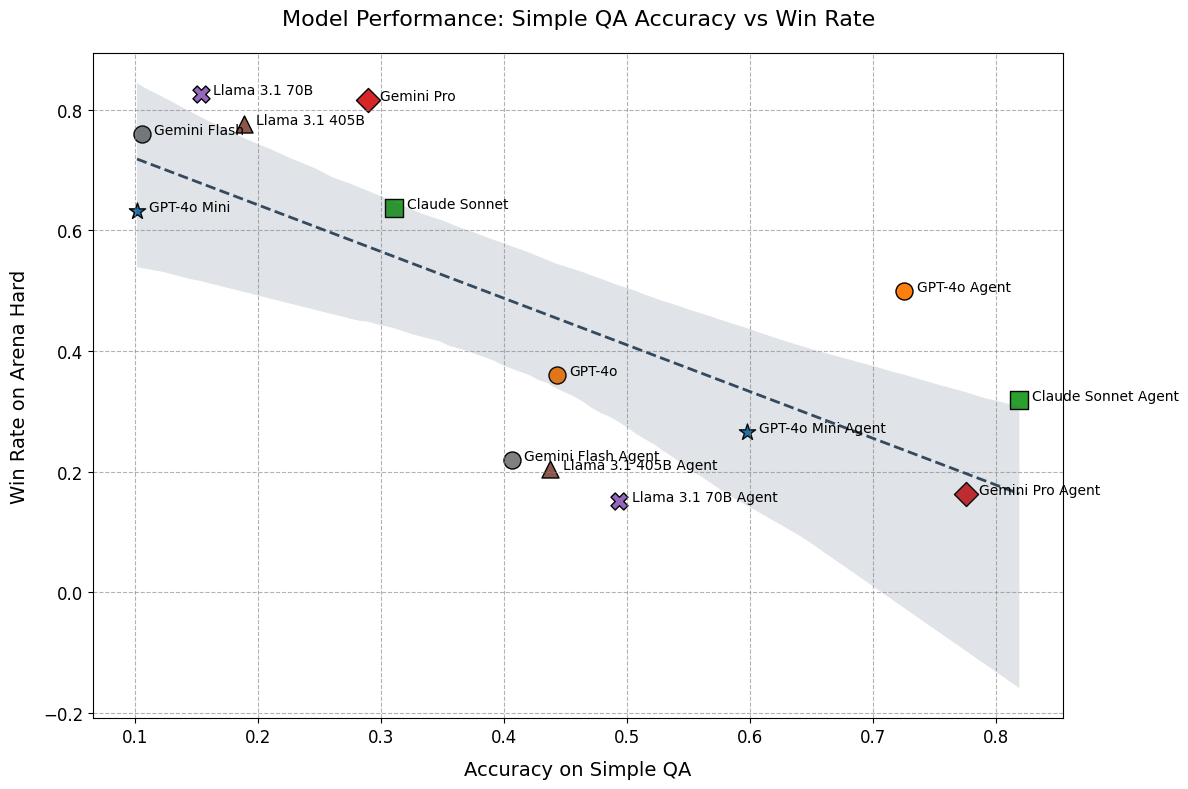

In [304]:
# Update model styles to handle both base and agent versions
model_styles = {
    "GPT-4o Mini": {"marker": "*", "color": "#1f77b4"},
    "GPT-4o": {"marker": "o", "color": "#ff7f0e"},
    "Claude Sonnet": {"marker": "s", "color": "#2ca02c"},
    "Gemini Pro": {"marker": "D", "color": "#d62728"},
    "Llama 3.1 70B": {"marker": "X", "color": "#9467bd"},
    "Llama 3.1 405B": {"marker": "^", "color": "#8c564b"},
}

# Function to map styles for both base and agent versions
def map_styles(name):
    base_name = name.replace(" Agent", "")
    return model_styles.get(base_name, {"marker": "o", "color": "gray"})

# Map styles for the plot data
plot_data["Style"] = plot_data["Model"].map(map_styles)

# Create plot
plt.figure(figsize=(12, 8))

# Plot each model with consistent style for base and agent versions
for _, row in plot_data.iterrows():
    plt.scatter(
        row["Simple QA Accuracy"],
        row["Win Rate"],
        label=row["Model"],
        s=150,
        edgecolor="black",
        marker=row["Style"]["marker"],
        color=row["Style"]["color"],
    )

sns.regplot(
    x="Simple QA Accuracy",
    y="Win Rate",
    data=plot_data,
    scatter=False,
    color="#34495e",
    line_kws={"linestyle": "dashed", "linewidth": 2}
)

# Annotate points with model names
for i in range(len(plot_data)):
    plt.text(
        plot_data["Simple QA Accuracy"].iloc[i] + 0.01,
        plot_data["Win Rate"].iloc[i],
        plot_data["Model"].iloc[i],
        fontsize=10,
        ha="left"
    )

# Title and labels
plt.title("Model Performance: Simple QA Accuracy vs Win Rate", fontsize=16, pad=20)
plt.xlabel("Accuracy on Simple QA", fontsize=14, labelpad=10)
plt.ylabel("Win Rate on Arena Hard", fontsize=14, labelpad=10)

# Customize ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.6, color="gray")

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title="Models")

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

### Ablations

In [167]:
model_error_ids = {}

for model_name in ["gpt-4o", "gpt-4o-mini"]:
    model_samples = pd.read_json("eval_samples/simple_qa_250_{}.jsonl".format(model_name), lines=True)
    you_agent_samples = pd.read_json("eval_samples/simple_qa_250_{}-agent.jsonl".format(model_name), lines=True)
    serp_agent_samples = pd.read_json("eval_samples/simple_qa_250_{}-agent_serp.jsonl".format(model_name), lines=True)
    ids = set()
    ids = ids.union(set(list(model_samples[model_samples["response"].str.lower().str.contains("network error due to high traffic")]["question_id"])))
    ids = ids.union(set(list(you_agent_samples[you_agent_samples["response"].str.lower().str.contains("network error due to high traffic")]["question_id"])))
    ids = ids.union(set(list(serp_agent_samples[serp_agent_samples["response"].str.lower().str.contains("network error due to high traffic")]["question_id"])))
    model_error_ids[model_name] = list(ids)

In [171]:
simple_qa_results_serp = {}

for model_name in ["gpt-4o", "gpt-4o-mini"]:
    simple_qa_results_serp[model_name] = pd.read_json("eval_results/simple_qa_250_{}_results.jsonl".format(model_name), lines=True)
    simple_qa_results_serp[model_name] = simple_qa_results_serp[model_name][~simple_qa_results_serp[model_name]["question_id"].isin(model_error_ids[model_name])]
    simple_qa_results_serp[model_name+"-you-agent"] = pd.read_json("eval_results/simple_qa_250_{}-agent_results.jsonl".format(model_name), lines=True)
    simple_qa_results_serp[model_name+"-you-agent"] = simple_qa_results_serp[model_name+"-you-agent"][~simple_qa_results_serp[model_name+"-you-agent"]["question_id"].isin(model_error_ids[model_name])]
    simple_qa_results_serp[model_name+"-serp-agent"] = pd.read_json("eval_results/simple_qa_250_{}-agent_serp_results.jsonl".format(model_name), lines=True)
    simple_qa_results_serp[model_name+"-serp-agent"] = simple_qa_results_serp[model_name+"-serp-agent"][~simple_qa_results_serp[model_name+"-serp-agent"]["question_id"].isin(model_error_ids[model_name])]

In [177]:
accuracy_serp = {}

for model_name in simple_qa_results_serp.keys():
    model_accuracy = float((simple_qa_results_serp[model_name]["grade"] == "A").mean())
    accuracy_serp[model_name] = model_accuracy
accuracy_serp

{'gpt-4o': 0.4553191489361702,
 'gpt-4o-you-agent': 0.7361702127659574,
 'gpt-4o-serp-agent': 0.7446808510638298,
 'gpt-4o-mini': 0.10526315789473684,
 'gpt-4o-mini-you-agent': 0.5964912280701754,
 'gpt-4o-mini-serp-agent': 0.6140350877192983}

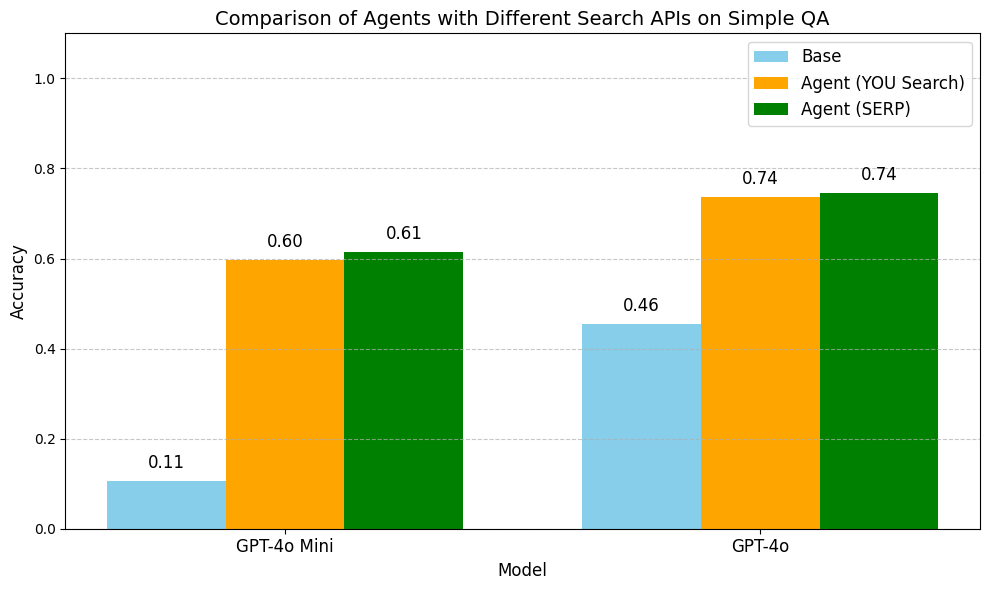

In [178]:
display_names = {"gpt-4o-mini": "GPT-4o Mini", "gpt-4o": "GPT-4o"}

models = ["gpt-4o-mini", "gpt-4o"]
base_accuracies = [accuracy_serp[model] for model in models]
you_agent_accuracies = [accuracy_serp[f"{model}-you-agent"] for model in models]
serp_agent_accuracies = [accuracy_serp[f"{model}-serp-agent"] for model in models]

plot_data = pd.DataFrame({
    "Model": models,
    "Base": base_accuracies,
    "You Agent": you_agent_accuracies,
    "Serp Agent": serp_agent_accuracies
})
plot_data["Model"] = plot_data["Model"].map(display_names)

x = np.arange(len(models))
width = 0.25
plt.figure(figsize=(10, 6))
base_bars = plt.bar(x - width, plot_data["Base"], width, label="Base", color="skyblue")
you_agent_bars = plt.bar(x, plot_data["You Agent"], width, label="Agent (YOU Search)", color="orange")
serp_agent_bars = plt.bar(x + width, plot_data["Serp Agent"], width, label="Agent (SERP)", color="green")

for i in range(len(models)):
    plt.text(x[i] - width, plot_data["Base"][i] + 0.02, f'{plot_data["Base"][i]:.2f}', ha='center', va='bottom', fontsize=12)
    plt.text(x[i], plot_data["You Agent"][i] + 0.02, f'{plot_data["You Agent"][i]:.2f}', ha='center', va='bottom', fontsize=12)
    plt.text(x[i] + width, plot_data["Serp Agent"][i] + 0.02, f'{plot_data["Serp Agent"][i]:.2f}', ha='center', va='bottom', fontsize=12)

plt.title("Comparison of Agents with Different Search APIs on Simple QA", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(x, plot_data["Model"], fontsize=12)
plt.ylim(0, 1.1)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

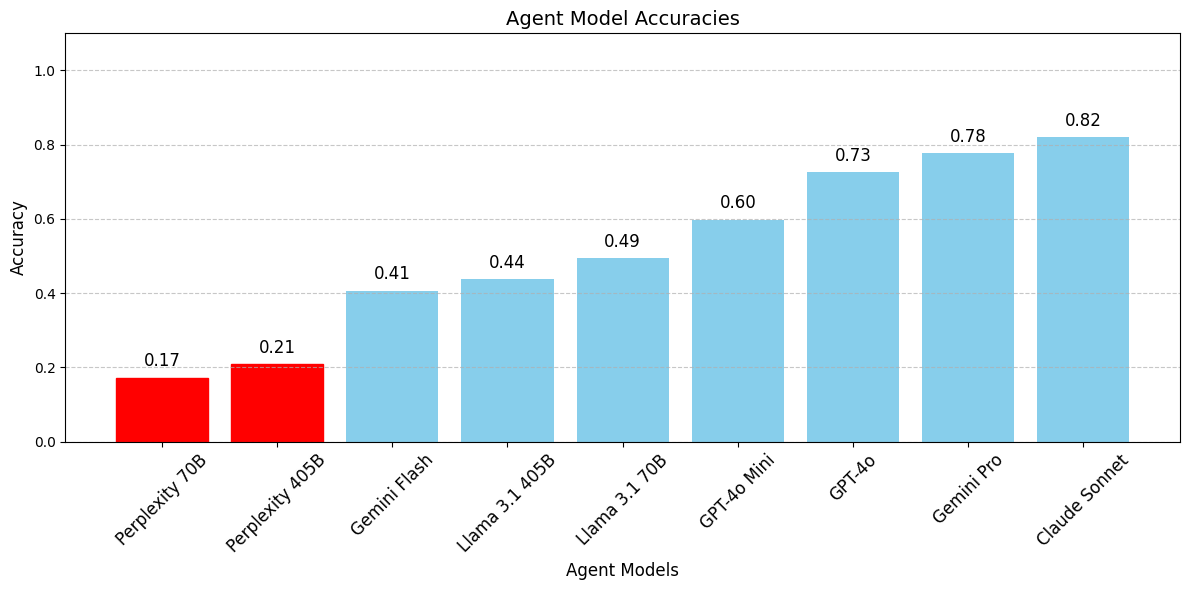

In [180]:
display_names = {"gpt-4o-mini-agent": "GPT-4o Mini", "gpt-4o-agent": "GPT-4o", "claude-3.5-sonnet-agent": "Claude Sonnet",
                "gemini-v1.5-flash-agent": "Gemini Flash", "gemini-v1.5-pro-agent": "Gemini Pro",
                "nvidia-llama31-70-agent": "Llama 3.1 70B", "nvidia-llama31-405-agent": "Llama 3.1 405B",
                "gemini-v1.5-flash-agent": "Gemini Flash", "ppl-llama31-70-agent": "Perplexity 70B",
                "ppl-llama31-405-agent": "Perplexity 405B"}

agent_data = {key: value for key, value in accuracy.items() if '-agent' in key}
plot_data = pd.DataFrame(list(agent_data.items()), columns=["Model", "Accuracy"])
plot_data["Model"] = plot_data["Model"].map(display_names)
plot_data = plot_data.sort_values(by="Accuracy", ascending=True).reset_index(drop=True)

plt.figure(figsize=(12, 6))
bars = plt.bar(plot_data["Model"], plot_data["Accuracy"], color="skyblue")

for i, bar in enumerate(bars):
    if i < 2:
        bar.set_color('red')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=12)

plt.title("Agent Model Accuracies", fontsize=14)
plt.xlabel("Agent Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [181]:
simple_qa = pd.read_json("eval_inputs/simple_qa_250.jsonl", lines=True)

llama_405_results = simple_qa_results["nvidia-llama31-405-agent"]
llama_405_samples = simple_qa_samples["nvidia-llama31-405-agent"]
ppl_405_results = simple_qa_results["ppl-llama31-405-agent"]
ppl_405_samples = simple_qa_samples["ppl-llama31-405-agent"]

llama_405_results = pd.merge(llama_405_results, llama_405_samples, on="question_id")
llama_405_results = pd.merge(llama_405_results, simple_qa, on="question_id")
ppl_405_results = pd.merge(ppl_405_results, ppl_405_samples, on="question_id")
ppl_405_results = pd.merge(ppl_405_results, simple_qa, on="question_id")

ppl_incorrect_indices = ppl_405_results[ppl_405_results["grade"] != "A"]["question_id"]
ppl_405_results = ppl_405_results.loc[ppl_405_results["question_id"].isin(ppl_incorrect_indices)]
llama_405_results = llama_405_results.loc[llama_405_results["question_id"].isin(ppl_incorrect_indices)]
llama_correct_indices = llama_405_results[llama_405_results["grade"] == "A"]["question_id"]

sample_point = llama_correct_indices.sample(1).iloc[0]
sample_point = "simple_qa_4"
print("Index: {}".format(sample_point))
print("### Question:\n{}\n".format(llama_405_results[llama_405_results["question_id"]==sample_point].iloc[0]['prompt']))
print("### Ground Truth Answer:\n{}\n".format(llama_405_results[llama_405_results["question_id"]==sample_point].iloc[0]['label']))
print("### Llama Model Answer:\n{}\n".format(llama_405_results[llama_405_results["question_id"]==sample_point].iloc[0]['response']))
print("### Perplexity Model Answer:\n{}\n".format(ppl_405_results[ppl_405_results["question_id"]==sample_point].iloc[0]['response']))

Index: simple_qa_4
### Question:
Who kills Daryl Garrs in Happy Valley?

### Ground Truth Answer:
Alison Garrs

### Llama Model Answer:
Daryl Garrs is killed by his mother, Alison Garrs, who shoots him in the back of the head to prevent him from going to prison for murder.
Reference Website: 

- [Alison Garrs | Happy Valley Wikia | Fandom](https://happy-valley.fandom.com/wiki/Alison_Garrs)

### Perplexity Model Answer:
The information provided in the search results does not specify who kills Daryl Garrs in Happy Valley. The mention of Daryl Garrs is found in [1], which only mentions that Daryl is a murderer from series two and that Catherine borrowed a car belonging to his mother, Alison Garrs (played by Susan Lynch), but it does not provide details about Daryl's death. For accurate information on Daryl Garrs' death, additional sources or specific episodes of Happy Valley would need to be consulted.
Reference Website: 

- https://www.imdb.com/name/nm0528462/news/
- https://parade.com/c